In [1]:
# solution to ultrasound kaggle
# by thenomemac-emailIsAt-gmail.com
# https://www.kaggle.com/c/ultrasound-nerve-segmentation/

In [2]:
import os
import time
import numpy as np
import skimage.transform
from skimage.io import imread
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
#test that images are being read in correctly
testimg1 = imread('./data/train/1_1.tif', plugin='matplotlib')
testimg2 = imread('./data/test/1.tif', plugin='matplotlib')

In [4]:
#verify image size and type
print(testimg1.shape)
print(testimg1.dtype)

(420, 580)
uint8


In [5]:
#verify test image size and type
print(testimg2.shape)
print(testimg2.dtype)

(420, 580)
uint8


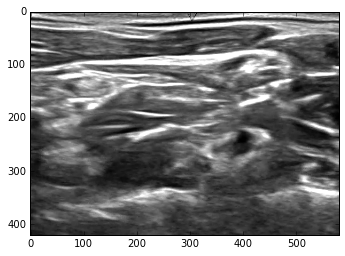

In [6]:
plt.gray()
plt.imshow(testimg1)

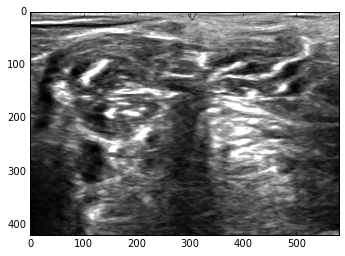

In [7]:
plt.imshow(testimg2)

In [8]:
# create list of image files and masks to load
XallNames = sorted([x for x in os.listdir('./data/train/') if 'mask' not in x])
YallNames = [x.replace('.tif', '_mask.tif') for x in XallNames]

print(len(XallNames))
print(len(YallNames))
print(XallNames[:10])
print(YallNames[:10])

5635
5635
['10_1.tif', '10_10.tif', '10_100.tif', '10_101.tif', '10_102.tif', '10_103.tif', '10_104.tif', '10_105.tif', '10_106.tif', '10_107.tif']
['10_1_mask.tif', '10_10_mask.tif', '10_100_mask.tif', '10_101_mask.tif', '10_102_mask.tif', '10_103_mask.tif', '10_104_mask.tif', '10_105_mask.tif', '10_106_mask.tif', '10_107_mask.tif']


In [9]:
# choose ~10% of patients to include in validation set
np.random.seed(333)
valNames = np.random.choice(range(1, 48), 5, replace=False)
valNames

array([22,  7, 47, 12, 44])

In [10]:
# filter to train and validation data sets
XvalNames = [x for x in XallNames if int(x.split('_')[0]) in valNames]
YvalNames = [y for y in YallNames if int(y.split('_')[0]) in valNames]

XtrainNames = [x for x in XallNames if int(x.split('_')[0]) not in valNames]
YtrainNames = [y for y in YallNames if int(y.split('_')[0]) not in valNames]

print(len(XvalNames))
print(len(YvalNames))
print(len(XtrainNames))
print(len(YtrainNames))
print(len(XvalNames) + len(YtrainNames) == len(XallNames))

598
598
5037
5037
True


In [11]:
# load training data
startTime = time.time()
Xtrain = np.asarray([imread(os.path.join('./data/train/', file), plugin='matplotlib') for file in XtrainNames])
endTime = time.time()

print('Min to load train data: {0}'.format((endTime - startTime) / 60))
print(Xtrain.shape)
print(Xtrain.dtype)
print(Xtrain[0])

Min to load train data: 0.9045036951700847
(5037, 420, 580)
uint8
[[  0 155 152 ...,  87  91  90]
 [  0 255 255 ..., 140 141 141]
 [  0 255 255 ..., 157 156 158]
 ..., 
 [  0  77  63 ..., 137 133 122]
 [  0  77  63 ..., 139 136 127]
 [  0  77  64 ..., 149 144 137]]


In [12]:
# load training data masks
startTime = time.time()
Ytrain = np.asarray([imread(os.path.join('./data/train/', file), plugin='matplotlib') for file in YtrainNames])
endTime = time.time()

print('Min to load train mask data: {0}'.format((endTime - startTime) / 60))
print(Ytrain.shape)
print(Ytrain.dtype)
print(Ytrain[0])

Min to load train mask data: 0.2876868406931559
(5037, 420, 580)
uint8
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [13]:
# load validation data
startTime = time.time()
Xval = np.asarray([imread(os.path.join('./data/train/', file), plugin='matplotlib') for file in XvalNames])
endTime = time.time()

print('Min to load val data: {0}'.format((endTime - startTime) / 60))
print(Xval.shape)
print(Xval.dtype)
print(Xval[0])

Min to load val data: 0.052305726210276286
(598, 420, 580)
uint8
[[  0  65  70 ...,  68  65  65]
 [  0 118 114 ..., 112 111 112]
 [  0 140 132 ..., 127 141 133]
 ..., 
 [  0  50  50 ...,  35  34  33]
 [  0  52  50 ...,  43  42  35]
 [  0  41  49 ...,  26  26  29]]


In [14]:
# load validation data masks
startTime = time.time()
Yval = np.asarray([imread(os.path.join('./data/train/', file), plugin='matplotlib') for file in YvalNames])
endTime = time.time()

print('Min to load val mask data: {0}'.format((endTime - startTime) / 60))
print(Yval.shape)
print(Yval.dtype)
print(Yval[0])

Min to load val mask data: 0.03614976803461711
(598, 420, 580)
uint8
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [15]:
# parameters on image size
IMAGE_W = 128
N_CHAN = 1

Before reshape:
 [[  0 155 152 ...,  87  91  90]
 [  0 255 255 ..., 140 141 141]
 [  0 255 255 ..., 157 156 158]
 ..., 
 [  0  77  63 ..., 137 133 122]
 [  0  77  63 ..., 139 136 127]
 [  0  77  64 ..., 149 144 137]]
After reshape:
 [[ 255.          255.          253.57666016 ...,  144.98583984
   132.72900391  142.55908203]
 [ 255.          255.          255.         ...,  126.30566406
   127.31225586  126.38574219]
 [ 139.56176758  137.79003906  144.88964844 ...,  150.77392578
   151.16186523  149.54125977]
 ..., 
 [  92.76855469   87.77001953   89.11035156 ...,  103.38647461  116.0300293
   115.96166992]
 [  73.66210937   84.07666016   98.4987793  ...,  127.57373047  122.125
   121.68676758]
 [  66.28125      73.56713867   92.8762207  ...,  135.97583008  145.96875
   137.98266602]]


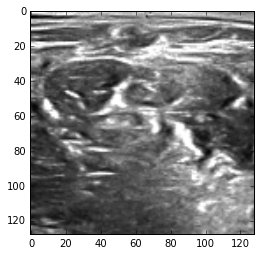

In [16]:
# QA on image resize
print('Before reshape:\n', Xtrain[0])

testimg3 = skimage.transform.resize(Xtrain[0], (IMAGE_W, IMAGE_W), preserve_range=True)
print('After reshape:\n', testimg3)

# plot with float values
plt.imshow(testimg3)

After cast:
 [[255 255 253 ..., 144 132 142]
 [255 255 255 ..., 126 127 126]
 [139 137 144 ..., 150 151 149]
 ..., 
 [ 92  87  89 ..., 103 116 115]
 [ 73  84  98 ..., 127 122 121]
 [ 66  73  92 ..., 135 145 137]]


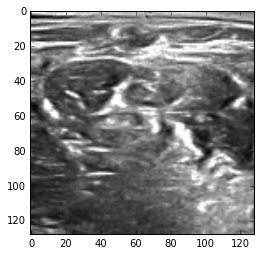

In [17]:
# cast to int
testimg4 = testimg3.astype('uint8')
print('After cast:\n', testimg4)

#plot with int values
plt.imshow(testimg4)

In [18]:
# convert masks to 0, 1
#Ytrain = np.where(Ytrain == 255, 1, 0)
np.where(Yval[0] == 255, 1, 0)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
# resize all images to 128
def resizeAndCast(x):
    return skimage.transform.resize(x, (IMAGE_W, IMAGE_W), preserve_range=True)

#Xtrain = np.array([np.round(resizeAndCast(img), 0) for img in Xtrain], dtype='uint8')
#Ytrain = np.array([np.round(resizeAndCast(np.where(img == 255, 1, 0)), 0) for img in Ytrain], dtype='uint8')
#Xval = np.array([np.round(resizeAndCast(img), 0) for img in Xval], dtype='uint8')
#Yval = np.array([np.round(resizeAndCast(np.where(img == 255, 1, 0)), 0) for img in Yval], dtype='uint8')

Xtrain = np.array([resizeAndCast(img) for img in Xtrain], dtype='float32')
Ytrain = np.array([resizeAndCast(np.where(img == 255, 1, 0)) for img in Ytrain], dtype='float32')
Xval = np.array([resizeAndCast(img) for img in Xval], dtype='float32')
Yval = np.array([resizeAndCast(np.where(img == 255, 1, 0)) for img in Yval], dtype='float32')

print(Xtrain.shape)
print(Ytrain.shape)
print(Xval.shape)
print(Yval.shape)

(5037, 128, 128)
(5037, 128, 128)
(598, 128, 128)
(598, 128, 128)


[-0.99651337 -0.97876358 -0.97270584 ...,  0.99214363  0.99217033
  0.9921875 ]


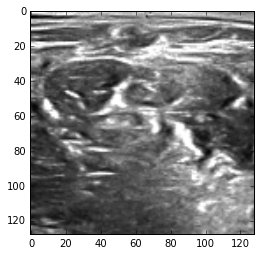

In [68]:
# plot to verify resize was done correctly
print(np.unique(Xtrain[0].reshape(128, 128)))
plt.imshow(Xtrain[0].reshape(128, 128))

[ 0.          0.00219727  0.02563477  0.0769043   0.109375    0.1159668
  0.140625    0.15356445  0.171875    0.17895508  0.20141602  0.25024414
  0.28198242  0.28833008  0.296875    0.31860352  0.32299805  0.328125
  0.390625    0.39575195  0.49682617  0.578125    0.79223633  0.796875
  0.82055664  0.859375    0.87475586  0.87670898  0.90112305  0.94018555
  0.97583008  1.        ]
[ 0.          0.0402832   0.04321289  0.12084961  0.1262207   0.14282227
  0.17456055  0.22729492  0.27026367  0.33569336  0.390625    0.515625
  0.56420898  0.56860352  0.640625    0.91137695  0.921875    0.95239258
  0.99047852  1.        ]


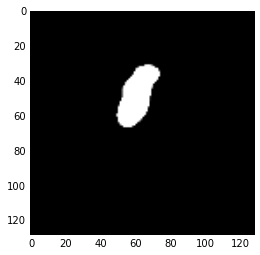

In [21]:
# plot to verify resize was done correctly
print(np.unique(Ytrain[0]))
print(np.unique(Yval[300]))
plt.imshow(Ytrain[0])

In [22]:
# reshape ndarray's 
Xtrain = Xtrain.reshape((-1, 1, IMAGE_W, IMAGE_W))
Ytrain = Ytrain.reshape((-1, 1, IMAGE_W, IMAGE_W))
Xval = Xval.reshape((-1, 1, IMAGE_W, IMAGE_W))
Yval = Yval.reshape((-1, 1, IMAGE_W, IMAGE_W))

In [23]:
# scale
mean = 128
sd = 128

print(np.unique(Xval[0]))

Xtrain -= mean
Xval -= mean
Xtrain  /= sd
Xval /= sd

print(np.unique(Xval[0]))

[   0.8190918     1.89526367    2.         ...,  254.91137695  254.99243164
  255.        ]
[-0.99360085 -0.98519325 -0.984375   ...,  0.99149513  0.99212837
  0.9921875 ]


In [24]:
# generator splitting an array into chunks of guranteed length N
def batches(array, min_batch):
    ix = list(range(len(array)))
    np.random.shuffle(ix)
    if len(array) % min_batch != 0:
        ix = np.concatenate((ix, \
                             np.random.randint(0, len(array), min_batch - (len(array) % min_batch))))
    for step in range(len(ix) // min_batch):
        yield ix[(step * min_batch):((step + 1) * min_batch)]
        
# QA on batch generation fxn
print(list(batches(Yval, 32)))
batchTest = np.sort(np.concatenate(list(batches(Yval, 32))))
#print(batchTest)
print(len(batchTest))
#print(Yval[list(batches(Yval, 32))[0]].shape)

[array([458, 350, 325,   5, 537, 154, 461, 261, 463, 588, 386, 176, 343,
       153, 526, 574, 509, 561,  55, 403, 144, 258, 108, 305, 247, 289,
       355, 341, 304, 206,  27,  29]), array([ 66, 582, 455, 170, 474, 125, 475, 459, 118,  87, 280,  46, 273,
       318,  93, 408, 276, 279, 507,  40, 185, 434, 546, 456, 293, 593,
       203, 330, 539, 301, 155, 414]), array([104, 545,  12, 310, 281, 211, 103, 194, 560, 554, 498,  60, 295,
       573, 540, 243, 160, 222, 397, 333, 450, 248,  76,  17, 469, 415,
        15, 416,  16, 396, 489, 491]), array([157, 454, 399, 133, 319,  79, 433, 506, 161, 464,  22, 443, 490,
        33, 205, 377, 569, 117, 366, 208, 188, 360, 369, 244, 374, 447,
       246, 364, 378, 595, 315, 182]), array([419, 381, 259,  19, 533, 317, 149, 299, 579,  67, 231,  14, 271,
       126, 494, 174, 527,  58, 442, 253, 371,  89, 233,  44, 171, 198,
       245, 111, 332, 312, 534, 287]), array([402, 594, 288, 424, 405, 548, 448, 536, 212, 387, 164, 512, 400,
       576, 

0.0119604
0.012882
[ 0.          0.09936523  0.171875    0.26147461  0.28833008  0.328125
  0.421875    0.44311523  0.57055664  0.58129883  0.62426758  0.69213867
  0.71166992  0.7199707   0.734375    0.75952148  0.765625    0.94067383
  0.94262695  0.9597168   1.        ]


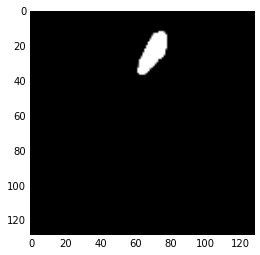

In [25]:
# test mean 1's in data
print(np.mean(Ytrain))
print(np.mean(Yval))

# use fxn to find images with non 0 masks
#np.where([np.sum(x) > 0 for x in Yval], range(len(Yval)), 0)
print(np.unique(Yval[23]))
plt.imshow(Yval[23].reshape(IMAGE_W, IMAGE_W))

In [26]:
import lasagne
import theano
import theano.tensor as T

from lasagne.layers import InputLayer
from lasagne.layers import Conv2DLayer as Conv
from lasagne.layers import Pool2DLayer as Pool
from lasagne.layers import Upscale2DLayer
from lasagne.layers import ConcatLayer
from lasagne.nonlinearities import sigmoid

# source ebenolson: https://gist.github.com/ebenolson/e298fcabf734f3c4ef13
def build_net(BATCH_N, N_CHAN, IMAGE_W):
    net = {}
    l = InputLayer((BATCH_N, N_CHAN, IMAGE_W, IMAGE_W))
    net['input'] = l

    l = Conv(l, 16, 3, pad='same')
    net['T4'] = l

    l = Conv(Pool(l, 2), 32, 3, pad='same')
    net['T3'] = l

    l = Conv(Pool(l, 2), 48, 3, pad='same')
    net['T2'] = l

    l = Conv(Pool(l, 2), 48, 3, pad='same')
    net['T1'] = l

    l = Conv(Conv(net['T1'], 48, 3, pad='same'), 48, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M1'] = l

    l = ConcatLayer((net['T2'], net['M1']))
    l = Conv(Conv(l, 48, 3, pad='same'), 32, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M2'] = l

    l = ConcatLayer((net['T3'], net['M2']))
    l = Conv(Conv(l, 32, 3, pad='same'), 16, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M3'] = l

    l = ConcatLayer((net['T4'], net['M3']))
    l = Conv(Conv(l, 16, 3, pad='same'), 1, 3, pad='same', nonlinearity=sigmoid)
    net['M4'] = l

    return net

In [32]:
import lasagne
import theano
import theano.tensor as T

from lasagne.layers import InputLayer
from lasagne.layers import Conv2DLayer as Conv
from lasagne.layers import Pool2DLayer as Pool
from lasagne.layers import Upscale2DLayer
from lasagne.layers import ConcatLayer
from lasagne.layers import batch_norm
from lasagne.nonlinearities import sigmoid

# source ebenolson: https://gist.github.com/ebenolson/e298fcabf734f3c4ef13
def build_net(BATCH_N, N_CHAN, IMAGE_W, X=None):
    net = {}
    l = InputLayer(shape=(BATCH_N, N_CHAN, IMAGE_W, IMAGE_W), input_var=X)
    net['input'] = l

    l = batch_norm(Conv(l, 16, 3, pad='same'))
    net['T4'] = l

    l = batch_norm(Conv(Pool(l, 2), 32, 3, pad='same'))
    net['T3'] = l

    l = batch_norm(Conv(Pool(l, 2), 48, 3, pad='same'))
    net['T2'] = l

    l = batch_norm(Conv(Pool(l, 2), 48, 3, pad='same'))
    net['T1'] = l

    l = batch_norm(Conv(net['T1'], 48, 3, pad='same'))
    l = batch_norm(Conv(l, 48, 3, pad='same'))
    l = Upscale2DLayer(l, 2)
    net['M1'] = l

    l = ConcatLayer((net['T2'], net['M1']))
    l = batch_norm(Conv(l, 48, 3, pad='same'))
    l = batch_norm(Conv(l, 32, 3, pad='same'))
    l = Upscale2DLayer(l, 2)
    net['M2'] = l

    l = ConcatLayer((net['T3'], net['M2']))
    l = batch_norm(Conv(l, 32, 3, pad='same'))
    l = batch_norm(Conv(l, 16, 3, pad='same'))
    l = Upscale2DLayer(l, 2)
    net['M3'] = l

    l = ConcatLayer((net['T4'], net['M3']))
    l = batch_norm(Conv(l, 16, 3, pad='same'))
    l = Conv(l, 1, 3, pad='same', nonlinearity=sigmoid)
    net['M4'] = l

    return net

In [89]:
import lasagne
import theano
import theano.tensor as T

from lasagne.layers import InputLayer
from lasagne.layers import Conv2DLayer as Conv
from lasagne.layers import Pool2DLayer as Pool
from lasagne.layers import Upscale2DLayer
from lasagne.layers import ConcatLayer
from lasagne.layers import batch_norm
from lasagne.layers import dropout
from lasagne.nonlinearities import sigmoid

# source ebenolson: https://gist.github.com/ebenolson/e298fcabf734f3c4ef13
def build_net(BATCH_N, N_CHAN, IMAGE_W, X=None):
    net = {}
    l = InputLayer(shape=(BATCH_N, N_CHAN, IMAGE_W, IMAGE_W), input_var=X)
    net['input'] = l

    l = batch_norm(Conv(l, 16, 3, pad='same'))
    net['T4'] = l

    l = dropout(batch_norm(Conv(Pool(l, 2), 32, 3, pad='same')), p=0.1)
    net['T3'] = l

    l = dropout(batch_norm(Conv(Pool(l, 2), 48, 3, pad='same')), p=0.1)
    net['T2'] = l

    l = dropout(batch_norm(Conv(Pool(l, 2), 48, 3, pad='same')), p=0.1)
    net['T1'] = l

    l = dropout(batch_norm(Conv(net['T1'], 48, 3, pad='same')), p=0.1)
    l = batch_norm(Conv(l, 48, 3, pad='same'))
    l = Upscale2DLayer(l, 2)
    net['M1'] = l

    l = ConcatLayer((net['T2'], net['M1']))
    l = batch_norm(Conv(l, 48, 3, pad='same'))
    l = batch_norm(Conv(l, 32, 3, pad='same'))
    l = Upscale2DLayer(l, 2)
    net['M2'] = l

    l = ConcatLayer((net['T3'], net['M2']))
    l = batch_norm(Conv(l, 32, 3, pad='same'))
    l = batch_norm(Conv(l, 16, 3, pad='same'))
    l = Upscale2DLayer(l, 2)
    net['M3'] = l

    l = ConcatLayer((net['T4'], net['M3']))
    l = batch_norm(Conv(l, 16, 3, pad='same'))
    l = batch_norm(Conv(l, 1, 3, pad='same', nonlinearity=sigmoid))
    net['M4'] = l

    return net

In [90]:
# input output ndarrays tensors
X = T.tensor4() # optionally make this tensor an input to the model input layer
Y = T.tensor4()

# build net
BATCH_N = 32
net = build_net(BATCH_N, N_CHAN, IMAGE_W, X=X)

# output
_EPSILON = 10e-8
output_train = T.clip(lasagne.layers.get_output(net['M4'], deterministic=False), _EPSILON, 1.0 - _EPSILON)
output_test = T.clip(lasagne.layers.get_output(net['M4'], deterministic=True), _EPSILON, 1.0 - _EPSILON)

# pixelwise loss
loss_train = T.mean(lasagne.objectives.binary_crossentropy(output_train.flatten(), Y.flatten()))
loss_test = T.mean(lasagne.objectives.binary_crossentropy(output_test.flatten(), Y.flatten()))

# dice coefficient
#dice = T.sum(T.where(T.gt(output.flatten(), 0.5), 1, 0) * Y.flatten()) * 2 / \
#    (T.sum(T.gt(output.flatten(), 0.5)) + T.sum(Y))

# model params to train
params = lasagne.layers.get_all_params(net['M4'], trainable=True) # trainable=True for batchnorm

# define update proceedure
updates = lasagne.updates.nesterov_momentum(loss_train, params, learning_rate=0.01, momentum=0.9)

f_predict = theano.function([X], output_test)
f_train = theano.function([X, Y], loss_train, updates=updates)
f_val = theano.function([X, Y], loss_test)

In [ ]:
### from lasagne.layers import get_output_shape, get_all_layers, count_params
import re

def printNetworkSummary(lastLayer):
    layers = get_all_layers(lastLayer)
    totalCnt = 0
    for layer in layers:
        layerName = re.search(r'<lasagne.layers[.]*(.+) object', str(layer)).group(1)
        layerCnt = count_params(layer) - totalCnt
        totalCnt = count_params(layer)
        layerShape = get_output_shape(layer)
        print('Name: {0} \t| Shape: {1} \t| Layer Params: {2}'.format(layerName, 
                                                                      layerShape, 
                                                                      layerCnt))
    print('Total Parameters: {0}'.format(totalCnt))
    
# print network details    
printNetworkSummary(net['M4'])

In [177]:
# train pixelwise model via minibatches

np.random.seed(333)
print('Starting Training...')

for epoch in range(10):
    start_time = time.time()
    loss_trn = 0
    cnt_trn = 0
    cnt_batch_trn = 0
    loss_val = 0
    cnt_val = 0
    cnt_batch_val = 0
    trnDict = {'loss_trn': [], 'loss_val': []}
    
    # iterate over mini batches for training
    for chunk in batches(Ytrain, BATCH_N):
        loss_trn_batch = f_train(Xtrain[chunk], Ytrain[chunk])
        trnDict['loss_trn'].append(loss_trn_batch)
        loss_trn += loss_trn_batch * len(chunk)
        cnt_trn += len(chunk)
        cnt_batch_trn += 1
        if cnt_batch_trn % 10 == 0:
            print('#', end='')
    
    # validation loss
    for chunk in batches(Yval, BATCH_N):
        loss_val_batch = f_val(Xval[chunk], Yval[chunk])
        trnDict['loss_val'].append(loss_val_batch)
        loss_val += loss_val_batch * len(chunk)
        cnt_val += len(chunk)
        cnt_batch_val += 1
    
    # compute epoch stats for printing
    loss_trn /= cnt_trn
    loss_val /= cnt_val
    end_time = time.time()
    wall_time = (end_time - start_time) / 60
    print('\n{0}\t| {1:0.2f}\t| {2:0.5f}\t| {3:0.5f}'.format(epoch, wall_time, loss_trn, loss_val))

Starting Training...
###############
0	| 17.21	| 0.03447	| 0.04788
###############
1	| 16.19	| 0.03279	| 0.04534
###############
2	| 16.53	| 0.03168	| 0.04763
###############
3	| 16.62	| 0.03052	| 0.04515
###############
4	| 16.71	| 0.02992	| 0.04451
###############
5	| 16.83	| 0.02885	| 0.04392
###############
6	| 16.71	| 0.02826	| 0.04488
###############
7	| 16.78	| 0.02783	| 0.04283
###############
8	| 16.97	| 0.02714	| 0.04318
###############
9	| 18.74	| 0.02684	| 0.04268


In [180]:
# predict masks for validation 

def batch_apply(X, f, batch_size):
    # function takes tensor and function and will force a batch size
    remainder = len(X) % batch_size
    if remainder != 0:
        iters = len(X) // batch_size + 1
        null_size = batch_size - remainder
    else: 
        iters = len(X) // batch_size
        null_size = 0
    
    out = []
    for i in range(iters):
        tmp = X[(i * batch_size):((i + 1) * batch_size)]
        if len(tmp) != batch_size:
            tmp = np.concatenate((tmp, np.zeros((null_size, 1, 128, 128))), axis=0)
            out.append(f(tmp)[:remainder])
        else:
            out.append(f(tmp))
        
    return np.concatenate(np.array(out))

YvalPred = batch_apply(Xval, f_predict, BATCH_N)

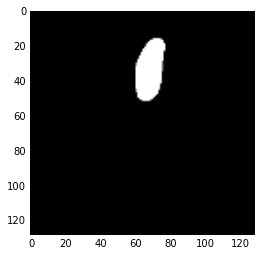

In [181]:
# compare actual mask
plt.imshow(Yval[300].reshape((128, 128)))

0.00720071561254
[ 0.0013737   0.00140735  0.00147756 ...,  0.97207683  0.97249929
  0.97407864]
(598, 1, 128, 128)


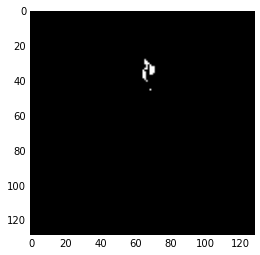

In [205]:
# compare predicted mask
print(np.mean(YvalPred))
print(np.unique(YvalPred))
print(YvalPred.shape)
plt.imshow((YvalPred[300] >= 0.5).astype('uint8').reshape((128, 128)))

0.0114620936399
[ 0.00328659  0.0032934   0.00331208 ...,  0.95265927  0.95279368
  0.95347778]
(598, 1, 128, 128)


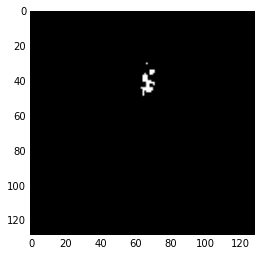

In [179]:
# compare predicted mask
print(np.mean(YvalPred))
print(np.unique(YvalPred))
print(YvalPred.shape)
plt.imshow((YvalPred[300] >= 0.35).astype('uint8').reshape((128, 128)))

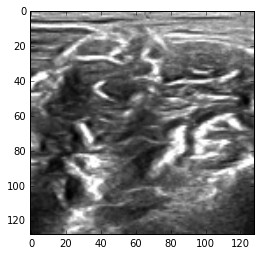

In [131]:
plt.imshow(Xval[300].reshape((128, 128)))

In [202]:
# mean after turning predictions to mask
print(np.mean(YvalPred >= 0.35))
print(np.mean([np.mean(x) > 0 for x in Ytrain])) # may want to filter all submissions to 0 not in top 40%
print(np.mean([np.mean(x > 0.5) > 0 for x in YvalPred])) # may want to filter all submissions to 0 not in top 40%

0.00280629033628
0.413341274568
0.178929765886


In [207]:
testy = T.tensor4()
testp = T.tensor4()

dice1 = theano.function([testy, testp],
    (2. * T.dot(testy.flatten(), T.transpose(testp.flatten())) + 1) / (T.sum(testy.flatten()) + T.sum(testp.flatten()) + 1))

print(dice1(Yval, YvalPred))
print(np.mean([dice1([y], [p]) for y, p in zip(Yval, YvalPred)]))

dice2 = theano.function([testy, testp], (T.sum(T.where(T.gt(testp.flatten(), 0.5), 1, 0) * testy.flatten()) * 2. + 1) / (T.sum(T.gt(testp.flatten(), 0.5)) + T.sum(testy.flatten()) + 1))

#print(dice2(Yval, YvalPred))
print(np.mean([dice2([y], [p]) for y, p in zip(Yval, YvalPred)]))

cut = 0.5

dice3 = lambda y, x: ((np.sum((np.ravel(x) > cut) * np.ravel(y)) * 2 + 1) / (np.sum((np.ravel(x) > cut)) + np.sum(np.ravel(y)) + 1))

#print(dice3(Yval, YvalPred))
print(np.mean([dice3([y], [p]) for y, p in zip(Yval, YvalPred)]))

print(np.mean([dice3([y], np.zeros((1, 1, 128, 128))) for y, p in zip(Yval, YvalPred)]))

0.22286670544001566
0.0986758485925
0.635598016554
0.635598016554
0.597809759523


In [209]:
# load train data and predict

XtestNames = sorted([x for x in os.listdir('./data/test/') if 'mask' not in x], key=lambda x: int(x[:-4]))
Xtest = np.asarray([imread(os.path.join('./data/test/', file), plugin='matplotlib') for file in XtestNames])
Xtest = np.array([resizeAndCast(img) for img in Xtest], dtype='float32')
Xtest -= mean
Xtest /= sd
print(Xtest[:1])

[[[ 0.9921875   0.9921875   0.9921875  ...,  0.09480476 -0.06388855
   -0.10296059]
  [ 0.24939728  0.23998642  0.25759315 ...,  0.47596169  0.61548615
    0.55367088]
  [-0.03547668 -0.03577614  0.05078888 ...,  0.00793457 -0.04850578
   -0.10299301]
  ..., 
  [-0.93873215 -0.95080566 -0.95410156 ..., -0.46228027 -0.45678711
   -0.4809227 ]
  [-0.95910645 -0.95544243 -0.9486084  ..., -0.10693359 -0.11865997
   -0.34553337]
  [-0.953125   -0.953125   -0.94421387 ...,  0.09715652  0.19254684
    0.16126823]]]


In [210]:
# predict for kaggle test data
YtestPred = batch_apply(Xtest.reshape((-1, 1, IMAGE_W, IMAGE_W)), f_predict, BATCH_N)
np.mean(YtestPred)

0.006971142756102262

In [217]:
# threshold the predictions
cuttest = 0.4
print(np.mean((YtestPred.reshape(-1, IMAGE_W, IMAGE_W) >= cuttest).astype('uint8')))
#YtestThreshold = (YtestPred.reshape(-1, IMAGE_W, IMAGE_W) >= cuttest).astype('uint8')

0.00175871672454


In [218]:
# upscale threshold
def upsizeAndCast(x):
    out = skimage.transform.resize(x.reshape(IMAGE_W, IMAGE_W), (420, 580), preserve_range=True)
    out = np.where(out >= cuttest, 255, 0).astype('uint8')
    return out

YtestThreshold = np.array([upsizeAndCast(img) for img in YtestPred], dtype='uint8')
print(YtestThreshold.shape)
print(np.mean(YtestThreshold)/255)

(5508, 420, 580)
0.00174354320272


In [219]:
def run_length_enc(label):
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])

YtestRun = [run_length_enc(img) for img in YtestThreshold]

In [220]:
# validate run length
YtestRun[:5]

['121070 2 121489 5 121908 10 122327 12 122746 14 123166 15 123586 15 124006 16 124426 16 124846 17 125266 18 125686 18 126106 19 126526 19 126947 18 127367 6 127374 11 127787 2 127795 10 128215 10 128636 9 129057 6',
 '',
 '118547 2 118966 5 119386 6 119806 7 120226 9 120646 10 121065 13 121484 15 121903 17 122311 30 122730 31 123150 32 123570 3 123577 25 123990 3 123999 23 124410 2 124420 22 124830 2 124840 22 125250 3 125259 23 125670 32 126090 32 126511 23 126535 7 126932 9 126942 11 126956 6 127353 6 127364 7 127376 6 127774 5 127785 4 127797 5 128196 2 128207 1 128219 2',
 '',
 '']

0.207334785766


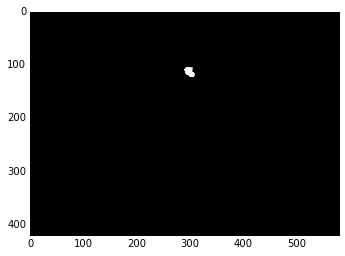

In [221]:
# QA
plt.imshow(YtestThreshold[0])
print(np.mean([np.mean(x) > 0 for x in YtestThreshold]))
#print(np.mean([np.mean(x) > 0 for x in Ytrain])) # may want to filter all submissions to 0 not in top 40%

In [222]:
# write test predictions to disk
import pandas as pd

pd.DataFrame({'img': range(1, len(YtestRun) + 1), 'pixels': YtestRun}).to_csv('sub7.csv', index=False)

In [223]:
# erase test set from memory
del(XtestNames)
del(Xtest)
del(YtestPred)
del(YtestThreshold)
del(YtestRun)

import gc
gc.collect()

7597

In [208]:
del(Xtrain)
del(XtrainNames)
del(XvalNames)
del(Ytrain)
del(Xval)
gc.collect()

3265

In [114]:
# input output ndarrays tensors
X = T.tensor4()
Y = T.tensor4()

# output
output = lasagne.layers.get_output(net['M4'])
_EPSILON = 10e-8
output = T.clip(output, _EPSILON, 1.0 - _EPSILON)

# pixelwise loss
loss = T.mean(lasagne.objectives.binary_crossentropy(output.flatten(), Y.flatten()))

# dice coefficient
#dice = T.sum(T.where(T.gt(output.flatten(), 0.5), 1, 0) * Y.flatten()) * 2 / \
#    (T.sum(T.gt(output.flatten(), 0.5)) + T.sum(Y))

# model params to train
params = lasagne.layers.get_all_params(net['M4'])

# define update proceedure
updates = lasagne.updates.rmsprop(loss, params, learning_rate=0.01)

f_predict = theano.function([X], output)
f_train = theano.function([X, Y], loss, updates=updates)
f_val = theano.function([X, Y], loss)

DisconnectedInputError:  
Backtrace when that variable is created:

  File "/home/thenome/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/thenome/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-112-3dd45f2a4850>", line 6, in <module>
    net = build_net(BATCH_N, N_CHAN, IMAGE_W)
  File "<ipython-input-111-966f9c035be0>", line 19, in build_net
    l = batch_norm(Conv(l, 16, 3, pad='same'))
  File "/home/thenome/.local/lib/python3.5/site-packages/lasagne/layers/normalization.py", line 370, in batch_norm
    layer = BatchNormLayer(layer, name=bn_name, **kwargs)
  File "/home/thenome/.local/lib/python3.5/site-packages/lasagne/layers/normalization.py", line 262, in __init__
    trainable=False, regularizable=False)
  File "/home/thenome/.local/lib/python3.5/site-packages/lasagne/layers/base.py", line 234, in add_param
    param = utils.create_param(spec, shape, name)
  File "/home/thenome/.local/lib/python3.5/site-packages/lasagne/utils.py", line 362, in create_param
    return theano.shared(arr, name=name)


In [ ]:
loss_trn = 0
cnt_trn = 0
cnt_batch_trn = 0
loss_val = 0
cnt_val = 0
cnt_batch_val = 0

# iterate over mini batches for training
for chunk in batches(Ytrain, BATCH_N):
    loss_trn_batch = f_val(Xtrain[chunk], Ytrain[chunk])
    loss_trn += loss_trn_batch * len(chunk)
    cnt_trn += len(chunk)
    cnt_batch_trn += 1
    if cnt_batch_trn % 10 == 0:
        print('#', end='')

# validation loss
for chunk in batches(Yval, BATCH_N):
    loss_val_batch = f_val(Xval[chunk], Yval[chunk])
    loss_val += loss_val_batch * len(chunk)
    cnt_val += len(chunk)
    cnt_batch_val += 1

# compute epoch stats for printing
loss_trn /= cnt_trn
loss_val /= cnt_val
wall_time = (endTime - startTime) / 3600
print('\n{0}\t| {1:0.2f}\t| {2:0.5f}\t| {3:0.5f}'.format(epoch, wall_time, loss_trn, loss_val))

In [74]:
loss_val, dice_val = f_val(Xval[:32].reshape((BATCH_N, 1, IMAGE_W, IMAGE_W)), Yval[:32].reshape((BATCH_N, 1, IMAGE_W, IMAGE_W)))
print(loss_val)
print(dice_val)

0.03018955663092653
0.0


In [246]:
max_batch = 32
array = Ytrain
np.concatenate((np.array([1,2,3]), np.random.randint(0, len(array), len(array) % max_batch)))

array([   1,    2,    3, 2605, 2847, 3775, 5025,  569, 1145,  286,  452,
       2567,  884, 4193, 2529,  926])

In [383]:
output = T.matrix()
Y = T.matrix()
test = theano.function([output, Y], T.sum(T.where(T.gt(output.flatten(), 0.5), 1, 0) * Y.flatten()) * 2 / (T.sum(T.gt(output.flatten(), 0.5)) + T.sum(Y)))
#print(test([1, 1, 0, 0], [1, 1, 0, 0]))
print(test(Yval[300], Yval[300]))
test2 = lambda x, y: (np.sum((x.ravel()>.5) * y.ravel()) * 2 / (np.sum((x.ravel()>.5)) + np.sum(y.ravel())))
print(test2(np.array([1, 1, 0, 0]), np.array([1, 1, 0, 0])))
print(test2(Yval[300], Yval[300]))

np.unique(Yval[300])

1.0
1.0
1.0


array([0, 1], dtype=uint8)

In [155]:
%timeit test = imread('./data/train/1_1.tif', plugin='matplotlib')

100 loops, best of 3: 3 ms per loop


In [152]:
%timeit test = plt.imread('./data/train/1_1.tif')

100 loops, best of 3: 3.04 ms per loop


In [273]:
ix = list(range(len(array)))
np.random.shuffle(ix)
if len(array) % max_batch != 0:
    ix = np.concatenate((ix, np.random.randint(0, len(array), max_batch - (len(array) % max_batch))))
array[32:64].shape

(32, 128, 128)

In [48]:
# convert to ndarray
Xtrain = np.asarray([x[1] for x in Xtrain])
Ytrain = np.asarray([y[1] for y in Ytrain])

In [51]:
# QA on loaded data dimensions and dtype
print(Xtrain.shape)
print(Xtrain.dtype)
print(Ytrain.shape)
print(Ytrain.dtype)

(5635, 420, 580)
uint8
(5635, 420, 580)
uint8


In [79]:
from lasagne.layers import InputLayer, DropoutLayer
from lasagne.layers import get_output_shape, get_all_layers, count_params
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Deconv2DLayer as DeconvLayer

net = {}
net['data'] = InputLayer(shape=(32, 1, 420, 580))

net['relu1_1'] = ConvLayer(net['data'], num_filters=64, filter_size=3, stride=1, pad='same')
net['relu1_2'] = ConvLayer(net['relu1_1'], num_filters=64, filter_size=3, stride=1, pad='same')
net['pool1'] = PoolLayer(net['relu1_2'], pool_size=2, stride=2)

net['relu2_1'] = ConvLayer(net['pool1'], num_filters=128, filter_size=3, stride=1, pad='same')
net['relu2_2'] = ConvLayer(net['relu2_1'], num_filters=128, filter_size=3, stride=1, pad='same')
net['relu2_3'] = ConvLayer(net['relu2_2'], num_filters=128, filter_size=3, stride=1, pad='same')
net['pool2'] = PoolLayer(net['relu2_3'], pool_size=2, stride=2)

net['relu3_1'] = ConvLayer(net['pool2'], num_filters=256, filter_size=3, stride=1, pad='same')
net['relu3_2'] = ConvLayer(net['relu3_1'], num_filters=256, filter_size=3, stride=1, pad='same')
net['relu3_3'] = ConvLayer(net['relu3_2'], num_filters=256, filter_size=3, stride=1, pad='same')
net['pool3'] = PoolLayer(net['relu3_3'], pool_size=2, stride=2)

net['relu4_1'] = ConvLayer(net['pool3'], num_filters=512, filter_size=3, stride=1, pad='same')
net['relu4_2'] = ConvLayer(net['relu4_1'], num_filters=512, filter_size=3, stride=1, pad='same')
net['relu4_3'] = ConvLayer(net['relu4_2'], num_filters=512, filter_size=3, stride=1, pad='same')
net['pool4'] = PoolLayer(net['relu4_3'], pool_size=2, stride=2)

net['relu5_1'] = ConvLayer(net['pool4'], num_filters=512, filter_size=3, stride=1, pad='same')
net['relu5_2'] = ConvLayer(net['relu5_1'], num_filters=512, filter_size=3, stride=1, pad='same')
net['relu5_3'] = ConvLayer(net['relu5_2'], num_filters=512, filter_size=3, stride=1, pad='same')
net['pool5'] = PoolLayer(net['relu5_3'], pool_size=2, stride=2)

net['relu6'] = ConvLayer(net['pool5'], num_filters=4096, filter_size=7, stride=1, pad='full')
net['drop6'] = DropoutLayer(net['relu6'], p=0.5)

net['relu7'] = ConvLayer(net['drop6'], num_filters=4096, filter_size=1, stride=1, pad='full')
net['drop7'] = DropoutLayer(net['relu7'], p=0.5)

net['score_fr'] = ConvLayer(net['drop7'], num_filters=21, filter_size=1, stride=1, pad='full')
net['upscore'] = DeconvLayer(net['score_fr'], num_filters=21, filter_size=64, stride=32, b=None)

In [80]:
def printNetworkSummary(netDict):
    for layer in netDict.items():
        print('Name: {0} \t; Output: {1} \t; Params: {2}'.format(layer[0], 
                                                             get_output_shape(layer[1]),
                                                             count_params(layer[1])))
    
printNetworkSummary(net)

Name: relu2_3 	; Output: (32, 128, 210, 290) 	; Params: 406592
Name: upscore 	; Output: (32, 21, 640, 800) 	; Params: 136299349
Name: relu1_1 	; Output: (32, 64, 420, 580) 	; Params: 640
Name: relu6 	; Output: (32, 4096, 19, 24) 	; Params: 117625664
Name: relu4_2 	; Output: (32, 512, 52, 72) 	; Params: 5421888
Name: relu5_3 	; Output: (32, 512, 26, 36) 	; Params: 14861120
Name: relu4_3 	; Output: (32, 512, 52, 72) 	; Params: 7781696
Name: pool5 	; Output: (32, 512, 13, 18) 	; Params: 14861120
Name: data 	; Output: (32, 1, 420, 580) 	; Params: 0
Name: pool4 	; Output: (32, 512, 26, 36) 	; Params: 7781696
Name: score_fr 	; Output: (32, 21, 19, 24) 	; Params: 134493013
Name: relu2_2 	; Output: (32, 128, 210, 290) 	; Params: 259008
Name: relu5_1 	; Output: (32, 512, 26, 36) 	; Params: 10141504
Name: drop7 	; Output: (32, 4096, 19, 24) 	; Params: 134406976
Name: pool3 	; Output: (32, 256, 52, 72) 	; Params: 1881920
Name: relu1_2 	; Output: (32, 64, 420, 580) 	; Params: 37568
Name: relu4_1 	

In [50]:
net[0]

KeyError: 0

In [369]:
import gc
gc.collect()

20860

In [43]:
Xtrain[40][0][:-4].split('_')[:2]

['10', '27.tif']

In [ ]:
# load training data in parallel
import multiprocessing
pool = multiprocessing.Pool()

def loadAllImgTrain(filename):
    return (filename, imread(os.path.join('./data/train/', filename), plugin='pil'))

startTime = time.time()
Xtrain =  pool.map(loadAllImgTrain, XtrainNames[:4])
endTime = time.time()
pool.terminate()

print('Min to load train data: {0}'.format((endTime - startTime) / 60))
print(len(Xtrain))
print(Xtrain[0])

In [ ]:
# split training data into train and validation
print('Min to load train data: ' % ((1/3) / 60))


In [ ]:
test.nbytes

In [ ]:
580*480*47*120

In [ ]:
Xtrain[99].nbytes

In [9]:
def f(x):
    return x**2

import multiprocessing
pool = multiprocessing.Pool()
test = pool.map(f, range(10))
print(test)
pool.terminate()

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [ ]:
startTime = time.time()
test = np.random.random((10000, 10000))
test = test.dot(test)
print(test.shape)
print(time.time() - startTime)

In [ ]:
del(test)

In [ ]:
np.__config__.show()